## 22 - 2 colours
>Create a map using only 2 colors. No gradients or shading—just two flat colors. This restriction encourages creativity in design and forces you to think about how to clearly convey your message with minimal color.

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
from shapely import Polygon, box
import cartopy.crs as ccrs
import numpy as np
import h3
import mapping_funcs as mf
from matplotlib.colors import Normalize
from matplotlib import patheffects as path_effects
from matplotlib_scalebar.scalebar import ScaleBar

In [4]:
## helper for filling shapely polygon (in lat lon) with h3 hexagons
# returns geodataframe of hexagon 
def fill_poly_with_hexagons(geometry, resolution=5):
    
    x, y = geometry.exterior.coords.xy
    h3_oly = h3.LatLngPoly(list(zip(y,x)))
    h3_hexes = h3.polygon_to_cells(h3_oly, resolution)
    h3_dicts = [h3.cells_to_geo([h]) for h in h3_hexes]
    polygons = [Polygon(h3dict['coordinates'][0]) for h3dict in h3_dicts]
    gdf = gpd.GeoDataFrame({'hex': h3_hexes},
                           geometry=polygons,
                           crs=4326)
    
    return gdf

In [ ]:
aoi = Polygon([
            [
              -5.884509875940694,
              57.04387602784371
            ],
            [
              -5.884509875940694,
              56.932156986770536
            ],
            [
              -5.482129807463451,
              56.932156986770536
            ],
            [
              -5.482129807463451,
              57.04387602784371
            ],
            [
              -5.884509875940694,
              57.04387602784371
            ]
          ])

osbg = ccrs.epsg(27700)

ld = ox.geocode_to_gdf('Lake District')

water = ox.features_from_polygon(ld.to_crs(4326).loc[0,'geometry'],
                                 tags={'natural':'water'}).to_crs(osbg)

river = ox.features_from_polygon(ld.to_crs(4326).loc[0,'geometry'],
                                 tags={'water':'river'}).to_crs(osbg)

dem = mf.DEM.get_copernicus_dem(ld.to_crs(osbg).buffer(11_000).to_crs(4326).geometry[0].envelope,
                                res=90,
                                rprj=False)

In [134]:
hexgdf = fill_poly_with_hexagons(ld.geometry[0],
                                 resolution=8)

centroids = gpd.GeoDataFrame(geometry=hexgdf.to_crs(osbg).centroid.to_crs(4326), crs=4326)
centroids['x'] = centroids.geometry.x
centroids['y'] = centroids.geometry.y

z = (dem
     .rename('z')
     .interp(x=centroids['x'].to_xarray(),
             y=centroids['y'].to_xarray())
     .to_dataframe()
     .drop(columns=['band', 'proj:epsg', 'platform', 'proj:shape', 'gsd', 'epsg'])
)

z = gpd.GeoDataFrame(z,
                     geometry=gpd.points_from_xy(z['x'], z['y']),
                     crs=4326).to_crs(osbg)
norm = Normalize(*z['z'].agg(['min', 'max']))

normS = norm(z['z'])
num_levels=10

binned = np.digitize(normS.data,
                     bins=np.linspace(0, 5.5, num_levels))
z['norm'] = 12*normS
z['bin'] = binned


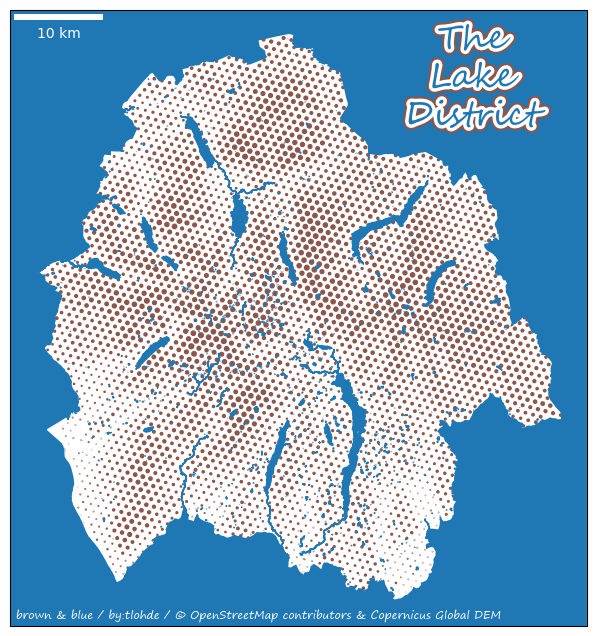

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection':osbg}, figsize=[8,8])

z.plot(markersize='norm', color='tab:brown', ax=ax, zorder=0)

water.plot(ax=ax, fc='tab:blue', ec='tab:blue', zorder=1)
river.plot(ax=ax, fc='tab:blue', ec='tab:blue', zorder=1)

ax.set_title('The\nLake\nDistrict',
             y=0.8,
             x=0.8,
             font='Segoe Script',
             fontsize=24,
             color='tab:blue',
             path_effects=[path_effects.Stroke(linewidth=8, foreground='tab:brown'),
                           path_effects.Stroke(linewidth=5, foreground='w'),
                           path_effects.Normal()])

minx, maxx = ax.get_xbound()
miny, maxy = ax.get_ybound()

gpd.GeoSeries(box(minx, miny, maxx, maxy)
              .symmetric_difference(ld.to_crs(osbg).geometry[0]),
              crs=osbg).plot(ax=ax,
                             fc='tab:blue')

ax.set(xlim=(minx, maxx),
       ylim=(miny, maxy))

ax.annotate('brown & blue / by:tlohde / © OpenStreetMap contributors & Copernicus Global DEM',
            xy=(0.01, 0.01),
            xycoords='axes fraction',
            font='Segoe Print',
            fontsize=8,
            color='w')

ax.add_artist(ScaleBar(1, location='upper left', color='w', box_alpha=0))

# fig.savefig('day22.png', dpi=300, bbox_inches='tight')